## Code for anlaysing feature impact

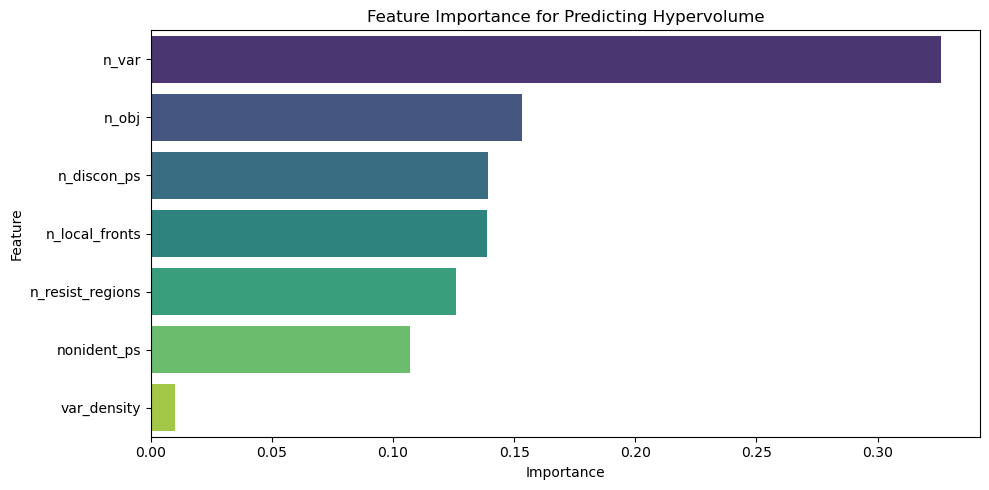

Top combinations worth exploring:
['n_var' 'n_obj' 'n_discon_ps']


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# Load dataset
df = pd.read_csv("C:\\Users\\aditi\\Downloads\\dbmopp_dataset_perf.csv", sep='\s+')

# Select features and target
feature_cols = ['n_var', 'n_obj', 'nonident_ps', 'var_density',
                'n_discon_ps', 'n_local_fronts', 'n_resist_regions']
X = df[feature_cols]
y = df['hypervolume']  # Target variable: performance metric

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Get feature importances
importances = rf.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(10, 5))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')
plt.title("Feature Importance for Predicting Hypervolume")
plt.tight_layout()
plt.show()

# Show most important combinations (optional)
print("Top combinations worth exploring:")
print(feature_importance_df.head(3)['Feature'].values)


## Benchamrking using on boorstrap resampling and Autorank for combination of feature and budget


AutoRank for group: High Combo - High Budget
        meanrank      mean       std  ci_lower  ci_upper effect_size  \
MOEAD        4.0  0.736286  0.003170  0.736035  0.736536         0.0   
Random       3.0  0.782492  0.002691  0.782279  0.782705   -15.71434   
NSGAII       2.0  0.841383  0.002683  0.841171  0.841595  -35.786389   
IBEA         1.0  0.856127  0.002678  0.855915  0.856339  -40.842339   

         magnitude effect_size_above magnitude_above  
MOEAD   negligible               0.0      negligible  
Random       large         -15.71434           large  
NSGAII       large        -21.914698           large  
IBEA         large         -5.500373           large  
The statistical analysis was conducted for 4 populations with 1000 paired samples.
The family-wise significance level of the tests is alpha=0.050.
We failed to reject the null hypothesis that the population is normal for all populations (minimal observed p-value=0.013). Therefore, we assume that all populations are n

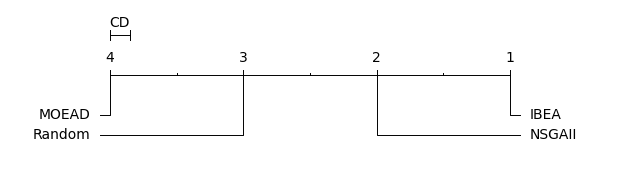

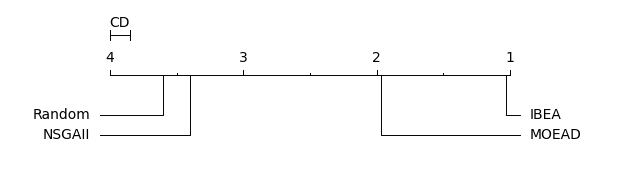

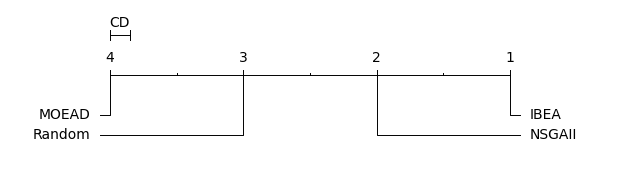

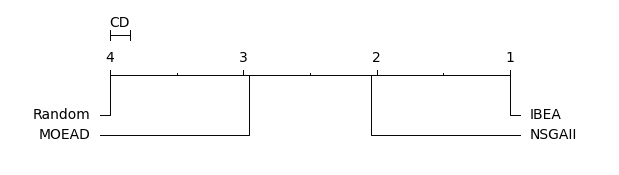

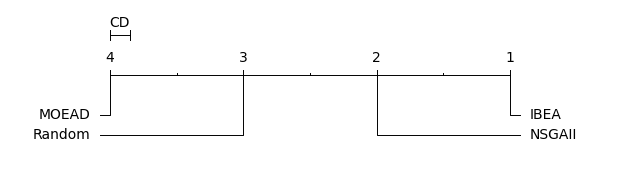

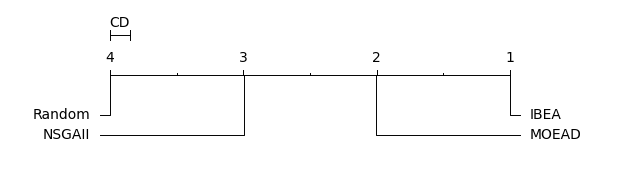

In [1]:
import pandas as pd
import numpy as np
from sklearn.utils import resample
from collections import defaultdict
from autorank import autorank, create_report, plot_stats
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")

# Load dataset
df = pd.read_csv("C:\\Users\\aditi\\Downloads\\dbmopp_dataset_perf.csv", sep='\s+')

# Define top features and group by feature combination
top_features = ['n_var', 'n_obj', 'n_discon_ps']
df['combo_group'] = np.where(
    (df['n_var'] > df['n_var'].median()) &
    (df['n_obj'] > df['n_obj'].median()) &
    (df['n_discon_ps'] > df['n_discon_ps'].median()),
    'High Combo', 'Low Combo'
)

# Define budget groups
low_budgets = [5000, 10000]
high_budgets = [30000, 50000]
df['budget_group'] = np.where(df['budget'].isin(low_budgets), 'Low Budget', 'High Budget')

# Combined group: Feature combo + Budget
df['combo_budget_group'] = df['combo_group'] + " - " + df['budget_group']

# Parameters
n_iterations = 1000
noise_std = 1e-4

results = []
mean_perf = []

# Analyze combo + budget groups
for group_name, group_df in df.groupby('combo_budget_group'):
    if len(group_df) < 10:
        continue

    algo_rank_counts = defaultdict(lambda: [0] * 4)
    local_mean_perf = []

    for _ in range(n_iterations):
        sample = resample(group_df, replace=True, n_samples=len(group_df))
        sample = sample.copy()
        sample['hypervolume'] += np.random.normal(0, noise_std, size=len(sample))

        mean_scores = sample.groupby('algo')['hypervolume'].mean().reset_index()
        mean_scores['combo_budget_group'] = group_name  # label group
        local_mean_perf.append(mean_scores)

        ranked = mean_scores.sort_values(by='hypervolume', ascending=False).reset_index(drop=True)
        for i, row in ranked.iterrows():
            algo_rank_counts[row['algo']][i] += 1

    mean_perf.extend(local_mean_perf)

    algorithms = sorted(algo_rank_counts.keys())
    result = {
        'Group': [group_name] * len(algorithms),
        'Algorithm': algorithms
    }
    for rank in range(4):
        result[f'Rank {rank+1} Freq'] = [algo_rank_counts[algo][rank] / n_iterations for algo in algorithms]

    results.append(pd.DataFrame(result))

    # AutoRank
    algo_scores_matrix = defaultdict(list)
    for df_iter in local_mean_perf:
        for _, row in df_iter.iterrows():
            algo_scores_matrix[row['algo']].append(row['hypervolume'])
    autorank_df = pd.DataFrame(algo_scores_matrix)

    try:
        print(f"\nAutoRank for group: {group_name}")
        stats = autorank(autorank_df, alpha=0.05, verbose=False)
        print(create_report(stats))
        plot_stats(stats)
    except Exception as e:
        print(f"AutoRank failed for {group_name}: {e}")

# Repeat for budget-only groups
for group_name, group_df in df.groupby('budget_group'):
    if len(group_df) < 10:
        continue

    algo_rank_counts = defaultdict(lambda: [0] * 4)
    local_mean_perf = []

    for _ in range(n_iterations):
        sample = resample(group_df, replace=True, n_samples=len(group_df))
        sample = sample.copy()
        sample['hypervolume'] += np.random.normal(0, noise_std, size=len(sample))

        mean_scores = sample.groupby('algo')['hypervolume'].mean().reset_index()
        mean_scores['budget_group'] = group_name
        local_mean_perf.append(mean_scores)

        ranked = mean_scores.sort_values(by='hypervolume', ascending=False).reset_index(drop=True)
        for i, row in ranked.iterrows():
            algo_rank_counts[row['algo']][i] += 1

    mean_perf.extend(local_mean_perf)

    algorithms = sorted(algo_rank_counts.keys())
    result = {
        'Group': [f"OnlyBudget - {group_name}"] * len(algorithms),
        'Algorithm': algorithms
    }
    for rank in range(4):
        result[f'Rank {rank+1} Freq'] = [algo_rank_counts[algo][rank] / n_iterations for algo in algorithms]

    results.append(pd.DataFrame(result))

    # AutoRank
    algo_scores_matrix = defaultdict(list)
    for df_iter in local_mean_perf:
        for _, row in df_iter.iterrows():
            algo_scores_matrix[row['algo']].append(row['hypervolume'])
    autorank_df = pd.DataFrame(algo_scores_matrix)

    try:
        print(f"\nAutoRank for budget group: {group_name}")
        stats = autorank(autorank_df, alpha=0.05, verbose=False)
        print(create_report(stats))
        plot_stats(stats)
    except Exception as e:
        print(f"AutoRank failed for {group_name}: {e}")

# Combine results and visualize
final_df = pd.concat(results, ignore_index=True).drop_duplicates().reset_index(drop=True)
perf_df = pd.concat(mean_perf, ignore_index=True)


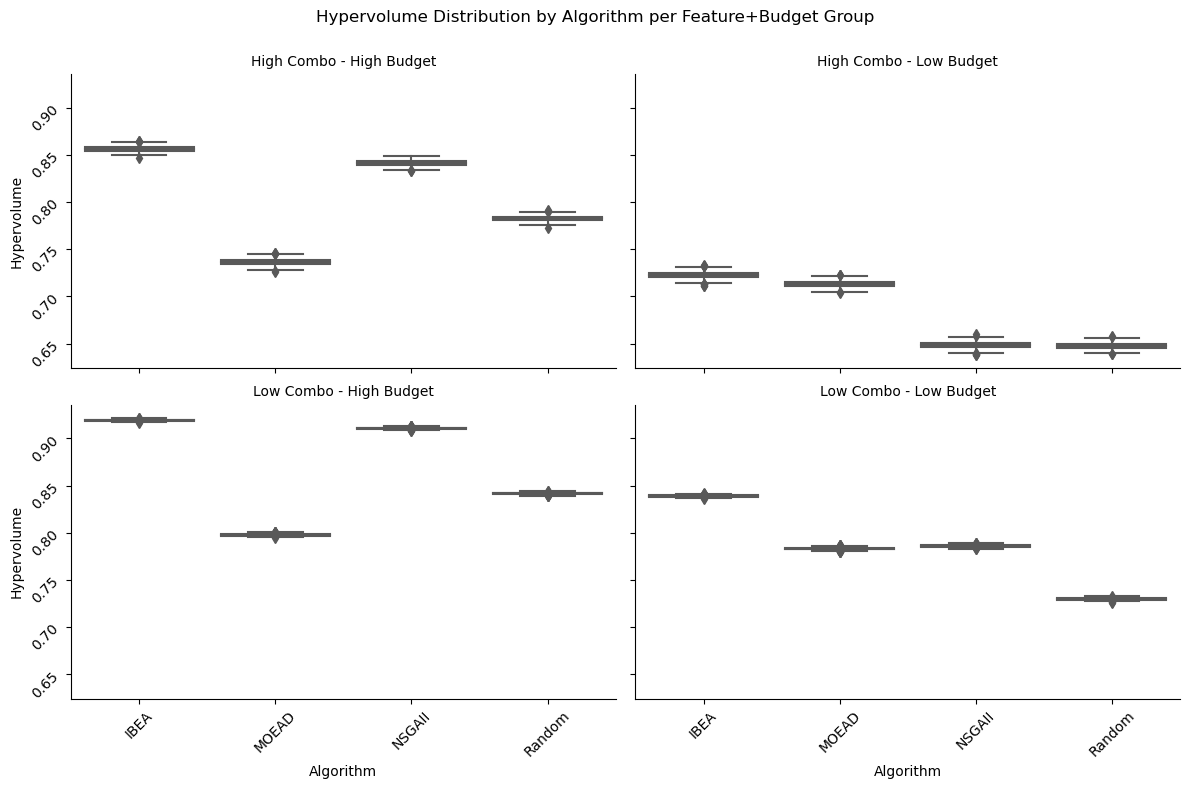

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

# FacetGrid for combo_budget_group
g = sns.FacetGrid(perf_df, col="combo_budget_group", col_wrap=2, height=4, aspect=1.5)
g.map_dataframe(sns.boxplot, x="algo", y="hypervolume", palette="Set2", order=["IBEA", "MOEAD", "NSGAII", "Random"])
g.set_titles(col_template="{col_name}")
g.set_axis_labels("Algorithm", "Hypervolume")
for ax in g.axes.flat:
    ax.tick_params(labelrotation=45)
plt.tight_layout()
plt.subplots_adjust(top=0.9)
g.fig.suptitle("Hypervolume Distribution by Algorithm per Feature+Budget Group")
plt.show()
